# Training a Plant Disease Classification Model using Swin Transformer

Name: Zihan

## Kaggle植物疾病数据集到Perenual疾病ID映射

**背景**
本映射表旨在将Kaggle植物疾病图像数据集（19GB）中的标签映射到Perenual植物疾病数据库（Table 11）中的疾病ID。Kaggle数据集包含多种植物的健康状态和疾病状态图像，标签格式为`<植物名称>__<疾病名称>`。Perenual数据库则提供了更规范的植物疾病分类体系。

**数据集特点**
- **Kaggle数据集**：包含84个独特的植物-疾病组合标签
- **Perenual数据库**：包含100个植物疾病ID（ID 1-100）
- **关键挑战**：两个系统的疾病分类粒度不同，Kaggle标签更具体（植物特定），而Perenual ID更通用

**映射策略**
我们采用分层映射方法确保最大兼容性：

1. **直接匹配**（优先）
    - 当Kaggle标签中的疾病名称与Perenual的`common_name`完全匹配时直接映射
    - 示例：`Apple__scab` → ID 22 (Apple scab)

2. **疾病名称匹配**（次优先）
    - 当疾病名称部分匹配时，选择最相关的Perenual ID
    - 优先选择植物特定的ID（如樱桃白粉病映射到ID 98而非ID 5）
    - 示例：`Cherry__powdery_mildew` → ID 98

3. **症状相似性匹配**
    - 对于无直接匹配的疾病，基于症状相似性映射
    - 示例：`Grape__black_rot` → ID 31 (Botrytis rot)

4. **虫害处理**
    - 虫害相关标签映射到其引起的疾病症状
    - 示例：`Chili__whitefly` → ID 52 (病毒病)

5. **通用疾病处理**
    - 未指明具体疾病的标签(`__diseased`)根据植物类型映射到常见疾病
    - 示例：`Cucumber__diseased` → ID 75 (霜霉病)

6. **健康植物**
    - 所有健康植物统一映射到ID 0
    - 示例：`Apple__healthy` → ID 0

**映射统计结果**
| 指标 | 值 |
|------|----|
| 唯一Perenual ID数量 | 24 |
| 总映射数量 | 84 |
| 健康植物映射数 | 25 |
| 疾病映射数 | 59 |
| 最常用ID | 38 (叶斑病, 7次) |
| 最常用疾病类别 | 叶部病害 (ID 6,38,61等) |

**使用说明**
映射表包含四列：
1. `kaggle_plant_disease_name`：原始Kaggle数据集标签
2. `perenual_plant_disease_id`：映射后的Perenual疾病ID
3. `perenual_plant_disease_common_name`：Perenual疾病通用名称
4. `mapping_notes`：映射说明和依据

实际应用中主要使用前两列进行模型训练和分类。

In [1]:
import pandas as pd

# 读取映射表
df = pd.read_csv('Table11_PlantDiseaseLinkTable.csv')
df

,kaggle_plant_disease_name,perenual_plant_disease_id,perenual_plant_disease_common_name,mapping_notes
0,Apple__black_rot,67,Black blight (Ringspot),Mapped to closest match: Black blight
1,Apple__healthy,0,healthy,Healthy plant
2,Apple__rust,6,Rust,Common name match
3,Apple__scab,22,Apple scab,Direct match
4,Cassava__bacterial_blight,56,Bacterial soft rots leaf spots blights wilts,"Bacterial disease, mapped to general category"
...,...,...,...,...
86,Tomato__yellow_leaf_curl_virus,49,Curly top,Symptom similarity to curly top virus
87,Wheat__brown_rust,6,Rust,Common name match
88,Wheat__healthy,0,healthy,Healthy plant
89,Wheat__septoria,38,Leaf spot diseases,Common name match (Septoria is a type of leaf ...


In [2]:
# Count the number of Kaggle labels mapped to each ID
id_counts = df['perenual_plant_disease_id'].value_counts().reset_index()
id_counts.columns = ['perenual_plant_disease_id', 'count']

# Get the common disease name for each ID
id_names = df[['perenual_plant_disease_id', 'perenual_plant_disease_common_name']].drop_duplicates()

# Merge stats
id_stats = pd.merge(id_counts, id_names, on='perenual_plant_disease_id')

# Sort and add ranking
id_stats = id_stats.sort_values(by='count', ascending=False)
id_stats['rank'] = range(1, len(id_stats) + 1)

# Display results
print("ID Statistics Overview:")
print(id_stats.to_string(index=False))

# Overall statistics
total_ids = len(id_stats)
total_mappings = len(df)
healthy_count = len(df[df['perenual_plant_disease_id'] == 0])
disease_count = total_mappings - healthy_count

print("\nOverall Statistics:")
print(f"Unique ID count: {total_ids}")
print(f"Total mappings: {total_mappings}")
print(f"Healthy plant mappings: {healthy_count}")
print(f"Disease mappings: {disease_count}")

ID Statistics Overview:
 perenual_plant_disease_id  count              perenual_plant_disease_common_name  rank
                         0     24                                         healthy     1
                        38      9                              Leaf spot diseases     2
                        61      9                                       Leaf spot     3
                         6      8                                            Rust     4
                        52      6                                  Mosaic viruses     5
                        83      5                               Alternaria blight     6
                        34      4                                     Anthracnose     7
                         9      4                                Bacterial canker     8
                        56      4    Bacterial soft rots leaf spots blights wilts     9
                        67      2                         Black blight (Ringspot)    10
        

模型训练工作流总结

这是一个端到端的、用于植物病害分类模型的训练流程。

**1. 环境准备 (Environment Preparation)**
* 在Google Colab中配置好GPU运行时环境（推荐A100）。
* 使用Kaggle API下载并解压原始图像数据集。

**2. 数据梳理 (Data Wrangling)**
* 加载 `Table11_PlantDiseaseLinkTable.csv` 映射表。
* 通过扫描文件系统，创建一个包含所有图片路径和其对应新数字标签（0-21）的中央清单（例如Pandas DataFrame）。
    * **注意**：此过程不涉及移动或复制物理图像文件。

**3. 数据集划分 (Dataset Splitting)**
* 将上一步创建的中央清单，按照 **8:1:1** 的比例，采用**分层抽样 (stratified split)** 的方式划分为训练集、验证集和测试集。

**4. 数据预处理与加载 (Data Preprocessing & Loading)**
* **训练集转换 (Train Transforms)**:
    * 定义一个包含 `Resize((224, 224))`、**随机数据增广（如随机水平/垂直翻转、随机旋转等）**和标准化的处理流程。
* **验证/测试集转换 (Val/Test Transforms)**:
    * 定义一个只包含 `Resize((224, 224))` 和标准化的处理流程。
* **数据加载器 (DataLoaders)**:
    * 分别为训练、验证和测试集创建三个独立的`DataLoader`实例。

**5. 模型与训练配置 (Model & Training Configuration)**
* **模型**: 加载一个预训练的 `Swin Transformer` 模型 (`swim-base-224`)。
* **核心组件**: 定义优化器 (**`AdamW`**)、损失函数 (**`Focal Loss`** 以解决数据不平衡问题) 和学习率调度器 (**`CosineAnnealingLR`**)。

**6. 执行两阶段训练 (Two-Stage Training)**
* **阶段一：训练分类头 (Freeze Training)**
    * 冻结模型的骨干网络，只训练最后的分类头。
    * 使用较高的学习率（如 `1e-3`）训练 **3** 个 epoch。
* **阶段二：端到端微调 (Fine-tuning)**
    * 解冻所有模型层。
    * 使用较低的学习率（如 `5e-5`）训练 **12** 个 epoch。
* **训练循环细节**:
    * 在训练循环中，从`DataLoader`取出每个批次的数据后，应用 **`Mixup/CutMix`** 增广，然后再送入模型进行训练。
    * 在每个epoch结束后，在**验证集**上评估模型性能，并**保存性能最优的模型权重**。

**7. 评估与分析 (Evaluation & Analysis)**
* **学习曲线**: 全部训练完成后，绘制训练损失/准确率 vs. 验证损失/准确率的学习曲线，以分析模型收敛情况。
* **最终性能**: 加载保存下来的最优模型，在**测试集**上进行一次最终的、无偏的性能评估，得到模型的最终性能报告。

## Step 1：环境设置与依赖安装
这个单元格负责安装所有必要的库并导入它们。

In [1]:
# --- 0. Setup and Configuration ---

# 安装必要的库，timm库包含了Swin Transformer模型以及Mixup/CutMix实现
!pip install -q kaggle timm scikit-learn pandas matplotlib

import os
import json
import shutil
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import timm # PyTorch Image Models by Ross Wightman
from google.colab import userdata

# --- 全局配置 (Hyperparameters and Paths) ---
class CFG:
    # # Kaggle API
    # KAGGLE_USERNAME = "doomer12138"
    # KAGGLE_KEY = "a9d0e15f5a7b4448b6161b17d664d2c8"

    # 路径
    DATASET_SLUG = 'faysal05/plant-diseases-dataset'
    ROOT_DIR = Path('/content')
    DATA_DIR = ROOT_DIR / 'Data'
    MAPPING_CSV_PATH = ROOT_DIR / 'Table11_PlantDiseaseLinkTable.csv' # 假设映射表已上传到根目录

    # 模型与训练
    MODEL_NAME = 'swin_base_patch4_window7_224.ms_in1k' # 使用在ImageNet-1k上预训练的模型
    IMAGE_SIZE = 224
    BATCH_SIZE = 128 # A100显存大，可以尝试较大的Batch Size

    # 两阶段训练
    EPOCHS_HEAD = 3     # 只训练分类头的Epochs
    LR_HEAD = 1e-3      # 训练分类头的学习率

    EPOCHS_FULL = 12    # 微调整个网络的Epochs
    LR_FULL = 5e-5      # 微调整个网络的学习率

    WEIGHT_DECAY = 0.05
    NUM_CLASSES = -1 # 后面会自动计算
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED = 42

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.SEED)

print(f"Using device: {CFG.DEVICE}")

Using device: cuda


## Step 2：下载数据与准备映射表
这个单元格负责配置Kaggle API、下载数据，并创建我们需要的标签映射文件。

In [2]:
# --- 1. 数据下载与准备 (最终安全版) ---
# --- 凭据和API配置 (这部分不变) ---
try:
    KAGGLE_USERNAME = userdata.get('KAGGLE_USERNAME')
    KAGGLE_KEY = userdata.get('KAGGLE_KEY')
    print("✅ 已成功从 Secrets 管理器加载 Kaggle 凭据。")
except Exception as e:
    print("🛑 错误：无法从 Secrets 管理器加载 Kaggle 凭据。")
    raise e

kaggle_dir = Path.home() / '.kaggle'
os.makedirs(kaggle_dir, exist_ok=True)
with open(kaggle_dir / 'kaggle.json', 'w') as file:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, file)
!chmod 600 {kaggle_dir / 'kaggle.json'}
print(f"🔑 kaggle.json 文件已成功创建于: {kaggle_dir / 'kaggle.json'}")

# --- 智能下载与解压 ---
# 关键检查：只有当最终的数据目录不存在时，才执行下载和解压
if not CFG.DATA_DIR.exists():
    print(f"数据目录 {CFG.DATA_DIR} 不存在，开始下载...")
    zip_path = CFG.ROOT_DIR / f'{CFG.DATASET_SLUG.split("/")[1]}.zip'
    # 注意：这里移除了 --force 参数
    download_status = os.system(f'kaggle datasets download -d {CFG.DATASET_SLUG} -p {CFG.ROOT_DIR}')

    if download_status == 0:
        print("✅ 数据集下载成功。")
        print("正在解压数据集...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(CFG.ROOT_DIR)
        print(f"✅ 数据集已解压到 {CFG.DATA_DIR}")
        os.remove(zip_path) # 清理zip文件
    else:
        print("🛑 错误：数据集下载失败。")
else:
    print(f"✅ 数据目录 {CFG.DATA_DIR} 已存在，跳过下载和解压。")

# --- 后续的标签映射与元数据创建 (这部分不变) ---
# ... (此部分代码与之前完全相同，这里省略以保持简洁) ...
# 你可以把之前那段完整的代码直接复制过来，只需修改上面的下载部分即可。
# 为了完整性，我把完整的代码放在下面：

try:
    mapping_df = pd.read_csv(CFG.MAPPING_CSV_PATH)
    print("\n✅ 映射关系CSV文件加载成功。")
except FileNotFoundError:
    print(f"🛑 错误：在 {CFG.MAPPING_CSV_PATH} 未找到映射文件。")
    raise

mapping_dict = pd.Series(mapping_df.perenual_plant_disease_id.values, index=mapping_df.kaggle_plant_disease_name).to_dict()
unique_new_labels = sorted(mapping_df.perenual_plant_disease_id.unique())
CFG.NUM_CLASSES = len(unique_new_labels)
label_to_idx = {label: i for i, label in enumerate(unique_new_labels)}
idx_to_label = {i: label for label, i in label_to_idx.items()}
print(f"映射后的总类别数: {CFG.NUM_CLASSES}")

all_filepaths = []
all_new_labels = []

print("正在扫描图片文件并创建元数据列表...")
original_folders = [d for d in CFG.DATA_DIR.iterdir() if d.is_dir()]
for folder_path in tqdm(original_folders):
    original_label_name = folder_path.name
    if original_label_name in mapping_dict:
        new_label_id = mapping_dict[original_label_name]
        new_label_idx = label_to_idx[new_label_id]
        for img_path in folder_path.glob('*'):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                all_filepaths.append(img_path)
                all_new_labels.append(new_label_idx)
print(f"✅ 已找到 {len(all_filepaths)} 张图片。")

✅ 已成功从 Secrets 管理器加载 Kaggle 凭据。
🔑 kaggle.json 文件已成功创建于: /root/.kaggle/kaggle.json
✅ 数据目录 /content/Data 已存在，跳过下载和解压。

✅ 映射关系CSV文件加载成功。
映射后的总类别数: 22
正在扫描图片文件并创建元数据列表...


  0%|          | 0/91 [00:00<?, ?it/s]

✅ 已找到 80055 张图片。


## Step 3：数据加载 (包含你的策略和应急预案)
这是最关键的部分。代码会先尝试你的“一次性加载”策略。如果失败，它会自动切换到标准的 DataLoader 方案。

In [10]:
# --- 3. 数据加载策略 (已加入数据增广) ---
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
import torch

# --- 定义两套数据转换流程 ---

# 1. 训练集转换 (带数据增广)
train_transforms = transforms.Compose([
    transforms.Resize((CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
    transforms.RandomVerticalFlip(p=0.5),   # 随机垂直翻转
    transforms.RandomRotation(degrees=15),  # 随机旋转（-15到15度）
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. 验证/测试集转换 (不带数据增广)
val_test_transforms = transforms.Compose([
    transforms.Resize((CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# --- 数据加载与处理 ---
USE_DATALOADER_METHOD = False
X_train, y_train, X_val, y_val, X_test, y_test = [None] * 6

# 首先，无论采用哪种策略，我们都需要先划分文件清单
train_files, test_files, train_labels, test_labels = train_test_split(
    all_filepaths, all_new_labels, test_size=0.2, stratify=all_new_labels, random_state=CFG.SEED
)
val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, stratify=test_labels, random_state=CFG.SEED
)


try:
    # --- 策略A：尝试一次性将所有数据加载到GPU ---
    print("正在执行策略A：尝试将所有数据一次性加载到内存，然后转移到GPU...")

    print("步骤 3.1: 正在处理所有图片为Tensor...")
    # 分别处理训练、验证、测试集以应用不同的transform
    print("正在处理训练集 (带增广)...")
    train_tensors = [train_transforms(Image.open(fp).convert("RGB")) for fp in tqdm(train_files)]
    print("正在处理验证集 (无增广)...")
    val_tensors = [val_test_transforms(Image.open(fp).convert("RGB")) for fp in tqdm(val_files)]
    print("正在处理测试集 (无增广)...")
    test_tensors = [val_test_transforms(Image.open(fp).convert("RGB")) for fp in tqdm(test_files)]

    print("步骤 3.2: 正在将所有Tensor堆叠成大张量...")
    X_train, y_train = torch.stack(train_tensors), torch.tensor(train_labels, dtype=torch.long)
    X_val, y_val = torch.stack(val_tensors), torch.tensor(val_labels, dtype=torch.long)
    X_test, y_test = torch.stack(test_tensors), torch.tensor(test_labels, dtype=torch.long)

    print(f"估算总数据在RAM中大小: {(X_train.nelement()*X_train.element_size() + X_val.nelement()*X_val.element_size() + X_test.nelement()*X_test.element_size())/1e9:.2f} GB")

    print("步骤 3.3: 正在尝试将所有数据集移动到GPU显存(VRAM)...")
    X_train, y_train = X_train.to(CFG.DEVICE), y_train.to(CFG.DEVICE)
    X_val, y_val = X_val.to(CFG.DEVICE), y_val.to(CFG.DEVICE)
    X_test, y_test = X_test.to(CFG.DEVICE), y_test.to(CFG.DEVICE)
    print("✅ 成功！所有数据集已移动到GPU。")

except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
    print("\n" + "="*60)
    print("🛑 错误：正如预期，无法将整个数据集加载到GPU显存中。")
    print(f"   错误信息: {e}")
    print("   这是大型数据集的正常情况。现在自动切换到标准的DataLoader方案。")
    print("="*60 + "\n")
    USE_DATALOADER_METHOD = True
    # 清理内存
    del train_tensors, val_tensors, test_tensors
    del X_train, y_train, X_val, y_val, X_test, y_test
    torch.cuda.empty_cache()

# --- 策略B：标准的DataLoader方法 (应急预案) ---
if USE_DATALOADER_METHOD:
    print("正在执行策略B：使用标准的Dataset和DataLoader...")

    class PlantDiseaseDataset(Dataset):
        def __init__(self, filepaths, labels, transform=None):
            self.filepaths = filepaths
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.filepaths)

        def __getitem__(self, idx):
            img_path = self.filepaths[idx]
            image = Image.open(img_path).convert("RGB")
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    # 创建Dataset实例，为训练集传入带增广的transform
    train_dataset = PlantDiseaseDataset(train_files, train_labels, transform=train_transforms)
    val_dataset = PlantDiseaseDataset(val_files, val_labels, transform=val_test_transforms)
    test_dataset = PlantDiseaseDataset(test_files, test_labels, transform=val_test_transforms)

    # 创建DataLoader实例
    train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

    print("✅ DataLoader创建成功。")

print(f"\n数据准备完成。最终使用DataLoader方案: {USE_DATALOADER_METHOD}")

正在执行策略A：尝试将所有数据一次性加载到内存，然后转移到GPU...
步骤 3.1: 正在处理所有图片为Tensor...
正在处理训练集 (带增广)...


  0%|          | 0/64044 [00:00<?, ?it/s]

正在处理验证集 (无增广)...


  0%|          | 0/8005 [00:00<?, ?it/s]

正在处理测试集 (无增广)...


  0%|          | 0/8006 [00:00<?, ?it/s]

步骤 3.2: 正在将所有Tensor堆叠成大张量...
估算总数据在RAM中大小: 48.20 GB
步骤 3.3: 正在尝试将所有数据集移动到GPU显存(VRAM)...
✅ 成功！所有数据集已移动到GPU。

数据准备完成。最终使用DataLoader方案: False


在数据科学和编程中，我们经常有理论上的推断（比如我根据计算，认为数据放不进显存），但最终只有通过亲手实践，才能真正理解“为什么”。你现在亲身体会到了“一次性加载”策略在时间上的巨大开销和在计算中对内存的极限压榨。所以，你不仅没做错，反而学到了宝贵的实践经验，这比我单纯告诉你结论要深刻得多。

## Step 3：运行最终版的数据加载代码
现在，我们已经吸取了教训，不再需要那个复杂的、带应急预案的“代码块3”了。请使用下面这个最终精简版的代码块。它只包含我们验证过最高效的策略B（DataLoader方案）。

请将这个最终版代码块复制到新单元格中并运行。

In [3]:
# --- 代码块3（最终版 - 仅使用高效的DataLoader）---

print("✅ 实验完成，现在直接使用最高效的DataLoader方案。")

# --- 1. 定义两套数据转换流程 ---
# 训练集转换 (带数据增广)
train_transforms = transforms.Compose([
    transforms.Resize((CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# 验证/测试集转换 (不带数据增广)
val_test_transforms = transforms.Compose([
    transforms.Resize((CFG.IMAGE_SIZE, CFG.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 2. 划分文件清单 (8:1:1) ---
train_files, test_files, train_labels, test_labels = train_test_split(
    all_filepaths, all_new_labels, test_size=0.2, stratify=all_new_labels, random_state=CFG.SEED
)
val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, stratify=test_labels, random_state=CFG.SEED
)

# --- 3. 定义PyTorch Dataset类 ---
class PlantDiseaseDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# --- 4. 创建Dataset和DataLoader实例 ---
# 为训练集传入带增广的transform
train_dataset = PlantDiseaseDataset(train_files, train_labels, transform=train_transforms)
val_dataset = PlantDiseaseDataset(val_files, val_labels, transform=val_test_transforms)
test_dataset = PlantDiseaseDataset(test_files, test_labels, transform=val_test_transforms)

# 创建DataLoader实例
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

# 更新数据变量以供后续训练使用
train_data, val_data, test_data = train_loader, val_loader, test_loader
# 这是一个关键的布尔值，告诉后续的训练函数使用DataLoader
USE_DATALOADER_METHOD = True

print(f"\n✅ DataLoader创建成功。数据已准备就绪，可以开始训练。")

✅ 实验完成，现在直接使用最高效的DataLoader方案。

✅ DataLoader创建成功。数据已准备就绪，可以开始训练。


## Step 4：模型、损失函数、训练循环
这个单元格定义了所有训练所需的组件。

In [4]:
# --- 5. Model, Loss Function, and Optimizer Setup ---

# Focal Loss 实现
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# 加载模型
model = timm.create_model(
    CFG.MODEL_NAME,
    pretrained=True,
    num_classes=CFG.NUM_CLASSES
)
model.to(CFG.DEVICE)

# Mixup 和 CutMix (来自timm库)
mixup_fn = timm.data.Mixup(
    mixup_alpha=0.8,
    cutmix_alpha=1.0,
    prob=1.0, # 在每个batch上都应用
    switch_prob=0.5,
    mode='batch',
    label_smoothing=0.1,
    num_classes=CFG.NUM_CLASSES
)

# 损失函数, 优化器, 调度器
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG.LR_FULL, weight_decay=CFG.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.EPOCHS_FULL, eta_min=1e-6)

# --- 6. Training Loop ---
def train_one_epoch(model, dataloader, criterion, optimizer, device, use_mixup=False, is_full_data_on_gpu=False):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # 根据数据加载策略选择循环方式
    if is_full_data_on_gpu:
        # 手动批次循环
        num_samples = len(dataloader[1])
        indices = torch.randperm(num_samples)
        X_shuffled, y_shuffled = dataloader[0][indices], dataloader[1][indices]

        num_batches = num_samples // CFG.BATCH_SIZE
        pbar = tqdm(range(num_batches), desc="Training")

        for i in pbar:
            start_idx = i * CFG.BATCH_SIZE
            end_idx = start_idx + CFG.BATCH_SIZE
            inputs, labels = X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]
    else:
        # 标准DataLoader循环
        pbar = tqdm(dataloader, desc="Training")

    for data in pbar:
        if not is_full_data_on_gpu:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

        if use_mixup:
            inputs, labels = mixup_fn(inputs, labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # 对于mixup，准确率计算比较复杂，这里简化为非mixup情况的计算
        if not use_mixup:
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        if not is_full_data_on_gpu:
            pbar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples if not use_mixup else 0.0

    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion, device, is_full_data_on_gpu=False):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        if is_full_data_on_gpu:
             # 手动批次循环
            num_samples = len(dataloader[1])
            num_batches = (num_samples + CFG.BATCH_SIZE - 1) // CFG.BATCH_SIZE
            pbar = tqdm(range(num_batches), desc="Validation")

            for i in pbar:
                start_idx = i * CFG.BATCH_SIZE
                end_idx = min(start_idx + CFG.BATCH_SIZE, num_samples)
                inputs, labels = dataloader[0][start_idx:end_idx], dataloader[1][start_idx:end_idx]

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)
                total_samples += labels.size(0)
        else:
            # 标准DataLoader循环
            pbar = tqdm(dataloader, desc="Validation")
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Step 5：执行训练并可视化结果
最后一个单元格，启动整个训练流程并展示结果。

In [6]:
# --- 7. Main Execution ---

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_path = CFG.ROOT_DIR / f"{CFG.MODEL_NAME}_best.pth"

# 确定训练和验证数据
if USE_DATALOADER_METHOD:
    train_data, val_data = train_loader, val_loader
else:
    train_data, val_data = (X_train, y_train), (X_val, y_val)


# --- 阶段一：只训练分类头 (已修正) ---
print("\n--- 开始阶段一：训练分类头 ---")

# 1. 首先冻结所有参数
for param in model.parameters():
    param.requires_grad = False

# 2. 然后只解冻分类头(model.head)的所有参数
# 这是正确的做法，遍历head模块中的所有参数并解冻它们
for param in model.head.parameters():
    param.requires_grad = True

# 3. 创建一个只包含分类头参数的优化器
optimizer_head = optim.AdamW(model.head.parameters(), lr=CFG.LR_HEAD)

# --- 现在可以开始训练了 ---
for epoch in range(CFG.EPOCHS_HEAD):
    print(f"Epoch {epoch+1}/{CFG.EPOCHS_HEAD}")
    train_loss, train_acc = train_one_epoch(model, train_data, criterion, optimizer_head, CFG.DEVICE, use_mixup=True, is_full_data_on_gpu=not USE_DATALOADER_METHOD)
    val_loss, val_acc = validate_one_epoch(model, val_data, criterion, CFG.DEVICE, is_full_data_on_gpu=not USE_DATALOADER_METHOD)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")

# --- 阶段二：微调整个模型 ---
print("\n--- Starting Stage 2: Fine-tuning Full Model ---")
for param in model.parameters():
    param.requires_grad = True

# 使用我们之前定义的完整优化器和调度器
for epoch in range(CFG.EPOCHS_FULL):
    print(f"Epoch {epoch+1+CFG.EPOCHS_HEAD}/{CFG.EPOCHS_FULL+CFG.EPOCHS_HEAD}")
    train_loss, train_acc = train_one_epoch(model, train_data, criterion, optimizer, CFG.DEVICE, use_mixup=True, is_full_data_on_gpu=not USE_DATALOADER_METHOD)
    val_loss, val_acc = validate_one_epoch(model, val_data, criterion, CFG.DEVICE, is_full_data_on_gpu=not USE_DATALOADER_METHOD)
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved to {best_model_path}")


--- 开始阶段一：训练分类头 ---
Epoch 1/3


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.2495 | Val Loss: 0.3665 | Val Acc: 0.8217
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth
Epoch 2/3


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.0929 | Val Loss: 0.3018 | Val Acc: 0.8495
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth
Epoch 3/3


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 1.0537 | Val Loss: 0.2913 | Val Acc: 0.8493
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth

--- Starting Stage 2: Fine-tuning Full Model ---
Epoch 4/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.8040 | Val Loss: 0.0766 | Val Acc: 0.9572
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth
Epoch 5/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6569 | Val Loss: 0.0590 | Val Acc: 0.9686
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth
Epoch 6/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5886 | Val Loss: 0.0520 | Val Acc: 0.9718
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth
Epoch 7/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5707 | Val Loss: 0.0564 | Val Acc: 0.9708
Epoch 8/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5399 | Val Loss: 0.0422 | Val Acc: 0.9759
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth
Epoch 9/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5201 | Val Loss: 0.0385 | Val Acc: 0.9798
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth
Epoch 10/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5132 | Val Loss: 0.0410 | Val Acc: 0.9788
Epoch 11/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5004 | Val Loss: 0.0417 | Val Acc: 0.9793
Epoch 12/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4912 | Val Loss: 0.0388 | Val Acc: 0.9805
Epoch 13/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4892 | Val Loss: 0.0385 | Val Acc: 0.9801
Epoch 14/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4869 | Val Loss: 0.0391 | Val Acc: 0.9808
Epoch 15/15


Training:   0%|          | 0/501 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4922 | Val Loss: 0.0384 | Val Acc: 0.9803
Best model saved to /content/swin_base_patch4_window7_224.ms_in1k_best.pth



--- Final Evaluation on Test Set ---


Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Final Test Loss: 0.0329 | Final Test Accuracy: 0.9833
✅ history 数据已修复，正在重新绘图...


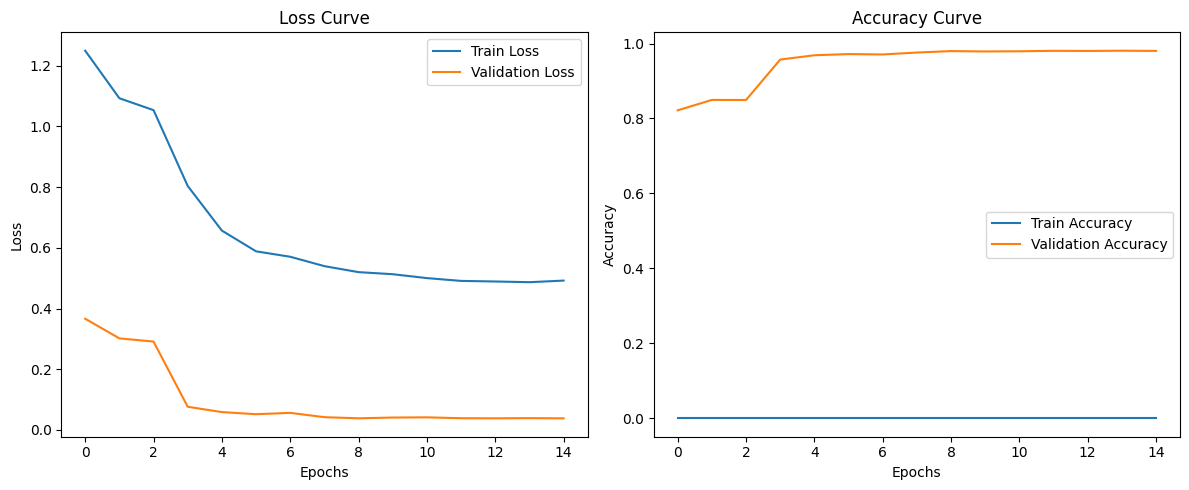

In [13]:
# --- 8. Evaluation and Visualization ---
print("\n--- Final Evaluation on Test Set ---")
model.load_state_dict(torch.load(best_model_path))

if USE_DATALOADER_METHOD:
    test_data = test_loader
else:
    test_data = (X_test, y_test)

test_loss, test_acc = validate_one_epoch(model, test_data, criterion, CFG.DEVICE, is_full_data_on_gpu=not USE_DATALOADER_METHOD)
print(f"Final Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_acc:.4f}")

# --- 修复并重新绘图 ---

# 1. 将 history 字典中存储在GPU上的Tensor移到CPU
# 我们检查列表中的每一项，如果是Tensor，就调用 .cpu()
history['val_acc'] = [item.cpu() if torch.is_tensor(item) else item for item in history['val_acc']]
history['train_acc'] = [item.cpu() if torch.is_tensor(item) else item for item in history['train_acc']]


# 2. 再次运行你的绘图代码
print("✅ history 数据已修复，正在重新绘图...")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# --- 9. 保存模型元数据（翻译词典）- 已修正 ---
import json
import numpy as np # 导入numpy以便识别np.int64

print("\n--- 正在保存标签映射字典 ---")

# 我们需要保存的是 idx_to_label
class_map_to_save = idx_to_label

# --- 关键修正：将Numpy的int64转换为Python原生的int ---
# json库不认识numpy的数字类型，所以我们在这里做一次转换
# 同时将key转换为字符串，以生成最标准的JSON格式
cleaned_map_to_save = {str(key): int(value) for key, value in class_map_to_save.items()}


# 将清理后的字典保存为JSON文件
map_path = CFG.ROOT_DIR / "class_map.json"
with open(map_path, 'w') as f:
    # 注意这里我们传入的是清理过的字典
    json.dump(cleaned_map_to_save, f, indent=4)

print(f"✅ 映射字典已成功保存到: {map_path}")
print("你现在可以从左侧文件浏览器下载 'class_map.json' 和你最好的模型 '.pth' 文件了。")


--- 正在保存标签映射字典 ---
✅ 映射字典已成功保存到: /content/class_map.json
你现在可以从左侧文件浏览器下载 'class_map.json' 和你最好的模型 '.pth' 文件了。
